In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('SentimentLabeled_10112022.csv')
df = df.drop_duplicates()
df['date'] = pd.to_datetime(df['date'])
df.head()

,date,text,userid_str,status_id_str,id,name,birth,term_partisanship,term_type,term_state,country,Bucket,SentimentScore,version
0,2015-09-28,I commend all of law enforcement for the secur...,156333623.0,6.485341e+17,3517566,Al Green,1947-09-01,Democrat,rep,TX,China,2 or 3,NaN,2019_batch1
1,2019-02-24,"Socialist tyrant Maduro starves, tortures his ...",235312723.0,1.099734e+18,3559992,Scott DesJarlais,1964-02-21,Republican,rep,TN,China,1,2.0,2019_batch1
2,2019-02-24,"Socialist tyrant Maduro starves, tortures his ...",235312723.0,1.099734e+18,3559992,Scott DesJarlais,1964-02-21,Republican,rep,TN,Iran,2 or 3,NaN,2019_batch1
3,2014-06-24,Inhofe: The Canadians have already had convers...,20546536.0,4.815273e+17,3468157,James M. Inhofe,1934-11-17,Republican,sen,OK,Canada,2 or 3,NaN,2019_batch1
4,2015-07-14,Statement on Iran nuclear agreement. http://t....,18773159.0,6.210401e+17,3833428,Scott Perry,1962-05-27,Republican,rep,PA,Iran,2 or 3,NaN,2019_batch1


### Data Cleaning

In [3]:
df.isnull().sum() # count empty values

date                    0
text                    0
userid_str            204
status_id_str        7748
id                      0
name                    0
birth                 204
term_partisanship     204
term_type               0
term_state              0
country                 0
Bucket               1229
SentimentScore       3491
version               204
dtype: int64

In [4]:
df['term_partisanship'].unique()

array(['Democrat', 'Republican', '{Republican}', '{Democrat}',
       'Independent', nan], dtype=object)

In [5]:
# remove {} from columns
df['term_partisanship'] = df['term_partisanship'].str.strip('{}')
df['term_type'] = df['term_type'].str.strip('{}')
df['term_state'] = df['term_type'].str.strip('{}')

In [6]:
df['term_type'].unique()

array(['rep', 'sen'], dtype=object)

In [7]:
df['term_type'] = df['term_type'].str.strip('{}') # remove {} from term_type column

In [8]:
df['Bucket'].unique()

array(['2 or 3', '1', '2', '3', nan, '1.0', '2.0', '3.0'], dtype=object)

In [9]:
df['Bucket'] = df['Bucket'].replace({'1.0':'1', '2.0':'2', '3.0':'3'})

In [10]:
df['SentimentScore'].unique()

array([ nan,  2. ,  4. ,  1.5,  3. ,  4.5,  5. ,  1. ,  0. ,  3.5,  2.5,
        0.5,  6. , 12. ])

In [11]:
df = df[df['SentimentScore'] <= 5]

### EDA

In [12]:
df['term_partisanship'].value_counts()

Republican     9244
Democrat       2605
Independent      45
Name: term_partisanship, dtype: int64

In [13]:
df['country'].value_counts()

China     9720
Iran      1352
Canada     944
Name: country, dtype: int64

In [14]:
df['Bucket'].value_counts()

1         10664
2           288
2 or 3       52
3            47
Name: Bucket, dtype: int64

In [15]:
df[df['Bucket'] == '1'].groupby(['country'])['SentimentScore'].mean()

country
Canada    3.818616
China     1.611086
Iran      1.597681
Name: SentimentScore, dtype: float64

Text(0.5, 1.0, 'Distribution of Sentiment Score by Country')

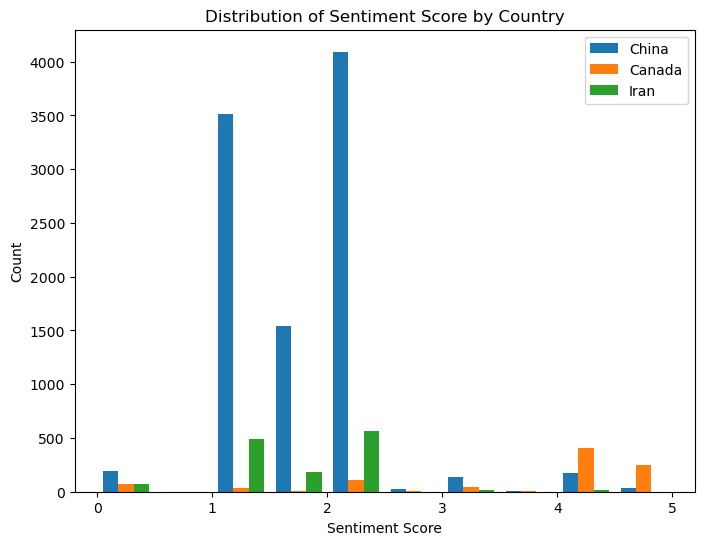

In [16]:
china = df[df['country'] == 'China']
canada = df[df['country'] == 'Canada']
iran = df[df['country'] == 'Iran']
plt.figure(figsize=(8,6))
plt.hist([china.SentimentScore, canada.SentimentScore, iran.SentimentScore], label=['China', 'Canada', 'Iran'])
plt.legend(loc='upper right')
plt.xlabel("Sentiment Score")
plt.ylabel("Count")
plt.title("Distribution of Sentiment Score by Country")

In [56]:
df_china = df[df['country'] == 'China']
df_count = df_china.groupby('name')['text'].count().to_frame().reset_index()
df_count = df_count.merge(df[['name', 'term_partisanship']], on='name', how='left')
df_count = df_count.drop_duplicates()

In [57]:
len(df_count)

587

Text(0.5, 1.0, 'Count of Tweets about China From All Parties ')

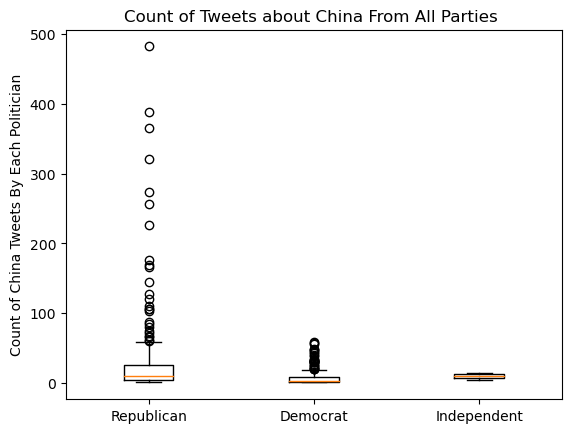

In [58]:
plt.boxplot([
    df_count[df_count['term_partisanship'] == 'Republican'].text,
    df_count[df_count['term_partisanship'] == 'Democrat'].text,
    df_count[df_count['term_partisanship'] == 'Independent'].text])
plt.xticks([1,2,3],['Republican', 'Democrat', 'Independent'])
plt.ylabel("Count of China Tweets By Each Politician")
plt.title("Count of Tweets about China From All Parties ")

In [54]:
df_count.sort_values(by='text')

,name,text,term_partisanship
11971,Zoe Lofgren,1,Democrat
1183,Burgess Owens,1,Republican
339,Ann Kuster,1,Democrat
338,Ann Kuster,1,Democrat
337,Ann Kuster,1,Democrat
...,...,...,...
7405,Marsha Blackburn,482,Republican
7406,Marsha Blackburn,482,Republican
7407,Marsha Blackburn,482,Republican
7383,Marsha Blackburn,482,Republican


In [52]:
df_china.groupby('term_partisanship').count()['date'] / (1910+20+7668)

term_partisanship
Democrat       0.199000
Independent    0.002084
Republican     0.798916
Name: date, dtype: float64

In [51]:
df_china['date'].max()

Timestamp('2021-08-11 00:00:00')

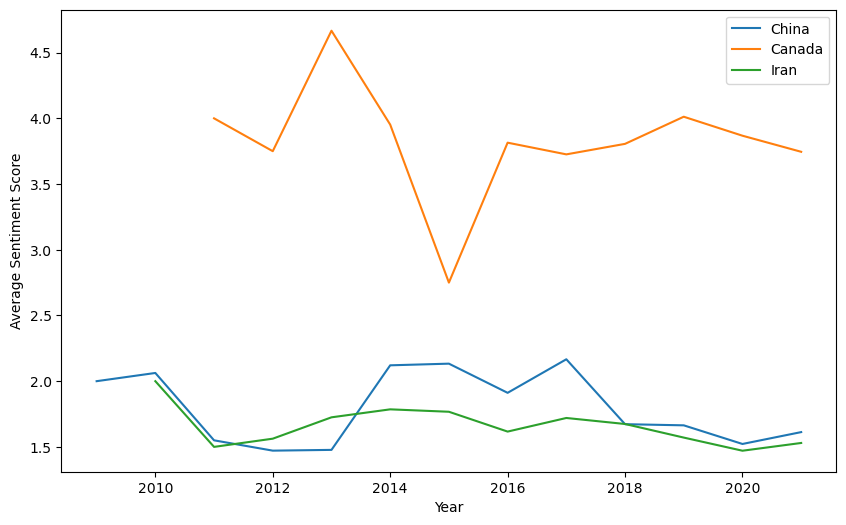

In [17]:
df_bucket1 = df[df['Bucket'] == '1'].set_index('date')
plt.figure(figsize=(10,6))
for c in df['country'].unique():
    dff = df_bucket1[df_bucket1['country'] == c]
    df_year = dff.groupby(dff.index.year)['SentimentScore'].mean().to_frame()
    plt.plot(df_year.index, df_year.SentimentScore, label=c)
dff = df_bucket1[df_bucket1['country'] == c]
    df_year = dff.groupby(dff.index.year)['SentimentScore'].mean().to_frame()
    plt.plot(df_year.index, df_year.SentimentScore, label=c)
plt.legend(loc='upper right')
plt.xlabel("Year")
plt.ylabel("Average Sentiment Score")
plt.show()

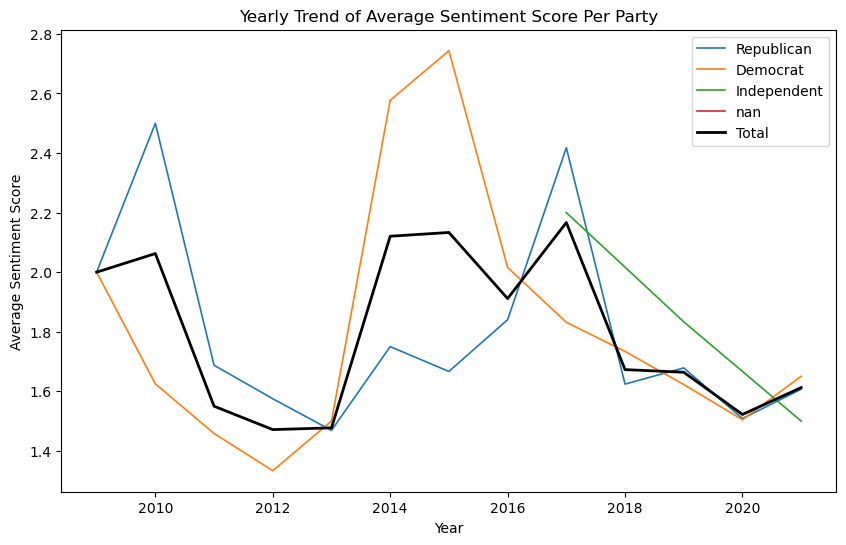

In [65]:
plt.figure(figsize=(10,6))
for p in df['term_partisanship'].unique():
    dff = df_bucket1[df_bucket1['term_partisanship'] == p]
    dff = dff[dff['country'] == 'China']
    df_party = dff.groupby(dff.index.year)['SentimentScore'].mean().to_frame()
    plt.plot(df_party.index, df_party.SentimentScore, label=p, linewidth=1.2)
dff = df_bucket1[df_bucket1['country'] == 'China']
df_party = dff.groupby(dff.index.year)['SentimentScore'].mean().to_frame()
plt.plot(df_party.index, df_party.SentimentScore, label='Total', color='black', linewidth=2)
plt.legend(loc='upper right')
plt.xlabel("Year")
plt.ylabel("Average Sentiment Score")
plt.title('Yearly Trend of Average Sentiment Score Per Party')
plt.show()

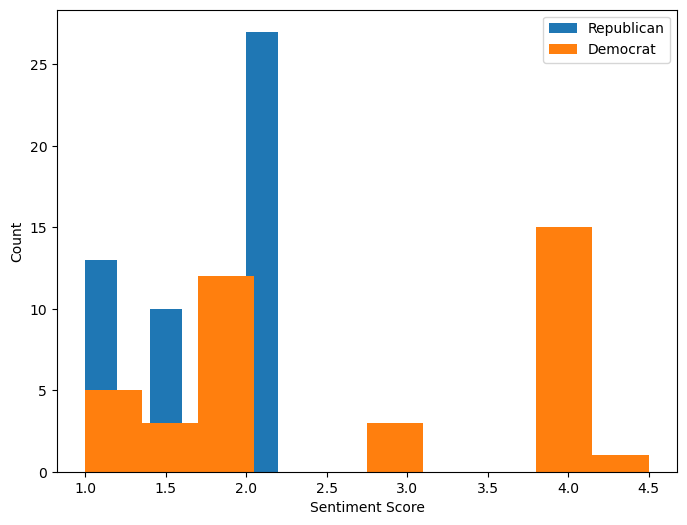

In [19]:
df_2015 = df_bucket1[(df_bucket1.index >= '2015-01-01') & (df_bucket1.index <'2016-01-01')]
df_2015 = df_2015[df_2015['country'] == 'China']
plt.figure(figsize=(8,6))
for p in df_2015['term_partisanship'].unique():
    dff = df_2015[df_2015['term_partisanship'] == p]
    plt.hist(dff.SentimentScore, label=p) 
plt.legend(loc='upper right')
plt.xlabel("Sentiment Score")
plt.ylabel("Count")
plt.show()

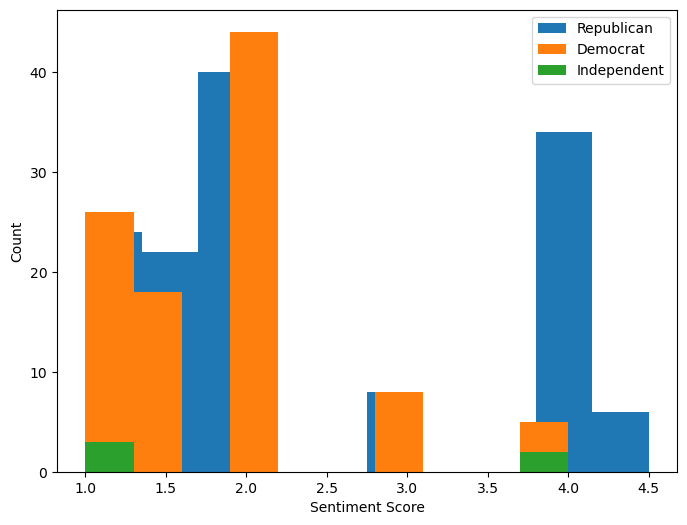

In [20]:
df_2017 = df_bucket1[(df_bucket1.index >= '2017-01-01') & (df_bucket1.index <'2018-01-01')]
df_2017 = df_2017[df_2017['country'] == 'China']
plt.figure(figsize=(8,6))
for p in df_2017['term_partisanship'].unique():
    dff = df_2017[df_2017['term_partisanship'] == p]
    plt.hist(dff.SentimentScore, label=p) 
plt.legend(loc='upper right')
plt.xlabel("Sentiment Score")
plt.ylabel("Count")
plt.show()